# GHD

## Imports

In [69]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

from skimage.transform import resize
from skimage.util.shape import view_as_windows
from skimage.feature import graycomatrix, graycoprops

from numba import jit, njit, prange

import cv2

from joblib import Parallel, delayed
import time



## Functions

In [11]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

## Load Images

In [13]:
def downsample(img, factor=2):
    return resize(img, (img.shape[0]//factor, img.shape[1]//factor), anti_aliasing=True)

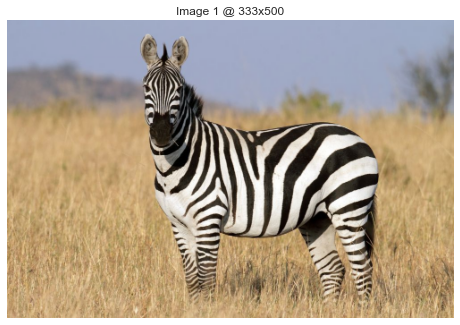

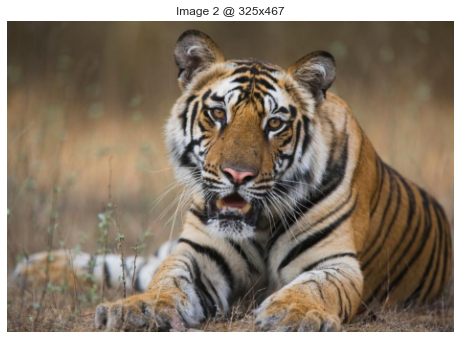

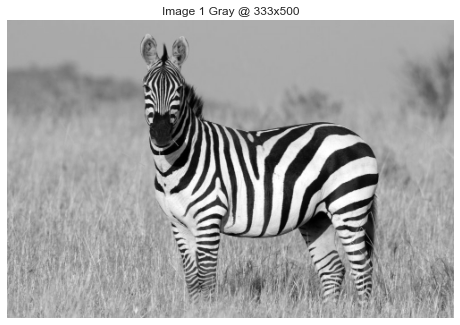

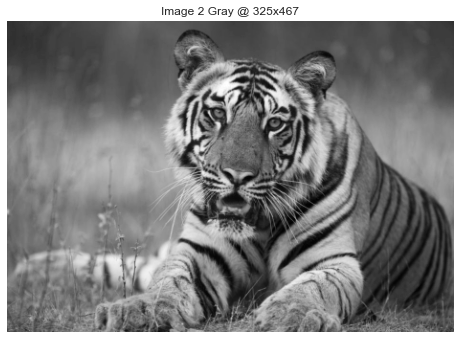

In [14]:
img1 = (downsample(rgb(cv2.imread('data\img1.jpg')), factor=2)*255).astype(np.uint8)
img1_gray = gray(img1)
img2 = (downsample(rgb(cv2.imread('data\img2.jpg')), factor=2)*255).astype(np.uint8)
img2_gray = gray(img2)

disp(img1, f'Image 1 @ {img1.shape[0]}x{img1.shape[1]}')
disp(img2, f'Image 2 @ {img2.shape[0]}x{img2.shape[1]}')

disp(img1_gray, f'Image 1 Gray @ {img1_gray.shape[0]}x{img1_gray.shape[1]}')
disp(img2_gray, f'Image 2 Gray @ {img2_gray.shape[0]}x{img2_gray.shape[1]}')

## GLCM Features

### get patches

In [59]:
def get_patches(img, patch_size=9, step_size=1, grayscale_levels=100):
    # reduce the number of levels in the image
    img = (img / 255 * grayscale_levels).astype(np.uint8)
    patches = view_as_windows(img, (patch_size, patch_size), step=step_size)
    return patches

def show_random_patches(patches, title=''):
    fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(8,8))
    fig.suptitle(title)
    for i in range(3):
        for j in range(3):
            axs[i,j].axis('off')
            axs[i,j].imshow(patches[np.random.randint(patches.shape[0]), np.random.randint(patches.shape[1])], cmap='gray')
    plt.show()

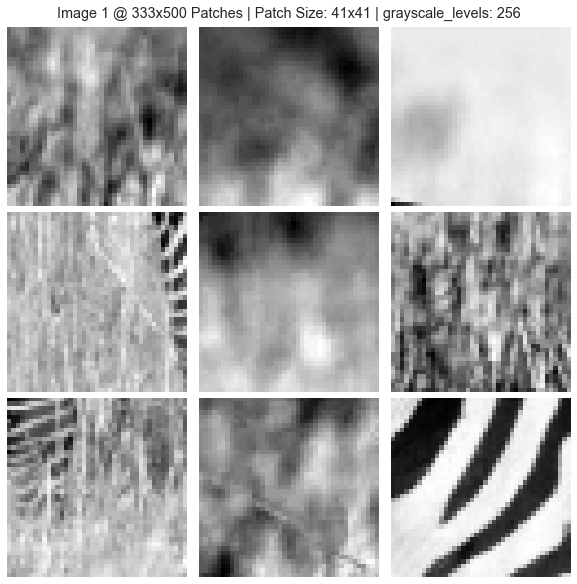

In [156]:
np.random.seed(2)
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=256)
show_random_patches(patches, title=f"Image 1 @ {img1_gray.shape[0]}x{img1_gray.shape[1]} Patches | Patch Size: 41x41 | grayscale_levels: 256")

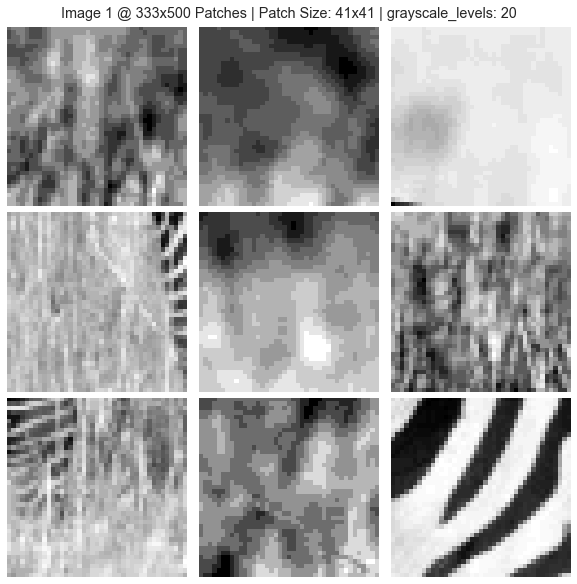

In [162]:
np.random.seed(2)
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=50)
show_random_patches(patches, title=f"Image 1 @ {img1_gray.shape[0]}x{img1_gray.shape[1]} Patches | Patch Size: 41x41 | grayscale_levels: 20")

In [163]:
np.random.seed(0)

### GLCM Feature Extraction

In [148]:
def get_glcm_features(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    start_time = time.time()
    for i in range(patches.shape[0]):
        time_elapsed = time.time() - start_time
        predicted_time = time_elapsed / (i+1) * patches.shape[0] - time_elapsed
        print(f'Processing row {i+1}/{patches.shape[0]} | Time Elapsed: {time_elapsed:.2f} secs | Time remaining: {predicted_time:.2f} secs', end='\r')
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm, 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm, 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm, 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm, 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm, 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm, 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

@jit
def get_glcm_features_numba(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    for i in range(patches.shape[0]):
        if i % 10 == 0:
            print(f'Processing row {i+1}/{patches.shape[0]}')
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm, 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm, 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm, 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm, 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm, 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm, 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

@jit(parallel=True)
def get_glcm_features_numba_parallel(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    for i in prange(patches.shape[0]): # Note the prange for the outer loop
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm.copy(), 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm.copy(), 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm.copy(), 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm.copy(), 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm.copy(), 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm.copy(), 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

In [173]:
def get_glcm_features_parallel(patches, levels=256, n_features=4):
    # GLCM features
    full_features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    def extract_features(patch):
        glcm = graycomatrix(patch.copy(), [1], [0], levels=levels, symmetric=True, normed=True)
        features = np.zeros(n_features)
        features[0] = graycoprops(glcm, 'dissimilarity')[0, 0]
        if n_features == 1:
            return features

        features[1] = graycoprops(glcm, 'correlation')[0, 0]
        if n_features == 2:
            return features

        features[2] = graycoprops(glcm, 'contrast')[0, 0]
        if n_features == 3:
            return features

        features[3] = graycoprops(glcm, 'homogeneity')[0, 0]
        if n_features == 4:
            return features

        features[4] = graycoprops(glcm, 'ASM')[0, 0]
        if n_features == 5:
            return features

        features[5] = graycoprops(glcm, 'energy')[0, 0]
        if n_features > 6:
            raise ValueError('Too many features requested')
        return features

    # Loop over patches in parallel
    nprocs = 10
    result = []
    result.extend(Parallel(n_jobs=nprocs)(delayed(extract_features)(patches[i,j]) for i in range(patches.shape[0]) for j in range(patches.shape[1])))
    result = np.array(result)
    full_features = result.reshape(patches.shape[0], patches.shape[1], n_features)

    return full_features

### Speed Improvements

In [191]:
%%time
# One patch per pixel
levels = 100
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=levels)
features = get_glcm_features(patches, levels=levels, n_features=5)
features.shape

KeyboardInterrupt: 

In [174]:
%%time
# One patch per pixel
levels = 50
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=levels)
features = get_glcm_features_parallel(patches, levels=levels, n_features=5)
features.shape

CPU times: total: 18 s
Wall time: 27.9 s


(293, 460, 5)

In [ ]:
# %%time
# # One patch per pixel
# levels = 2
# patches = get_patches(img1_gray, patch_size=9, step_size=1, grayscale_levels=levels)
# features = get_glcm_features_numba(patches, levels=levels, n_features=3)
# features.shape

In [ ]:
# %%time
# # One patch per pixel
# levels = 2
# patches = get_patches(img1_gray, patch_size=9, step_size=1, grayscale_levels=levels)
# features = get_glcm_features_numba_parallel(patches, levels=levels, n_features=3)
# features.shape

## Clustering using K-Means

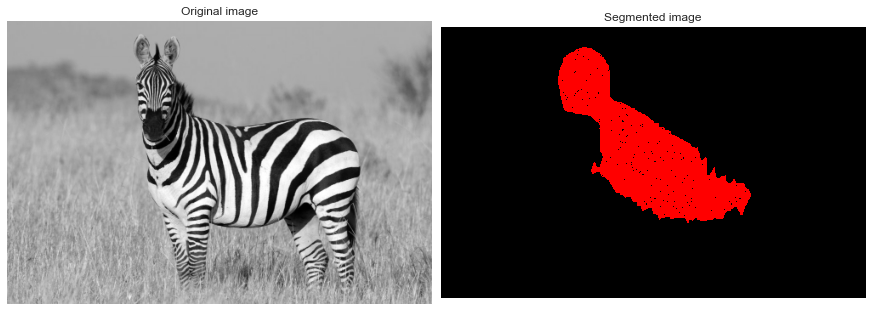

In [189]:
from sklearn.cluster import KMeans
from matplotlib import colors


kmeans = KMeans(n_clusters=2, random_state=2).fit(features.reshape(-1, features.shape[-1]))
labels = kmeans.labels_.reshape(features.shape[:2])

# Colormap
# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'red'])
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# plot labels
fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
ax[0].imshow(img1_gray, cmap='gray')
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(labels, cmap=cmap, norm=norm)
ax[1].set_title('Segmented image')
ax[1].set_axis_off()
plt.show()
